In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')


In [6]:
import sqlite3
conn = sqlite3.connect('inventory.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('begin_inventory',), ('end_inventory',), ('purchases',), ('purchase_prices',), ('sales',), ('vendor_invoice',), ('vendor_sales_summary',)]


Loading the dataset

In [7]:
#creating database connection
conn= sqlite3.connect('inventory.db')

#fetching vendor summary data
df = pd.read_sql_query("select * from vendor_sales_summary",conn)
df.head()


,VendorNumber,VendorName,Brand,Description,PurchasePrice,volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,1750.0,36.99,145080,3811251.60,2398823.72,66628.0,362685.77,122420.51,68601.68,-1412427.88,-58.880020,0.459250,0.629406
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,1750.0,28.99,164038,3804041.22,2112837.32,69864.0,301099.74,128367.34,144929.24,-1691203.90,-80.044208,0.425901,0.555419
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,1750.0,24.99,187407,3418303.68,2203070.30,89720.0,251522.47,164852.05,123780.22,-1215233.38,-55.160899,0.478744,0.644492
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,1750.0,22.99,201682,3261197.94,2259913.38,100362.0,229028.12,184407.36,257032.07,-1001284.56,-44.306325,0.497625,0.692970
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,1750.0,29.99,138109,3023206.01,2054581.50,66050.0,290832.18,121359.28,257032.07,-968624.51,-47.144614,0.478245,0.679604


Exploratory Data Analysis

1. Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

2. In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [9]:
# summary statistics

df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,1.065065e+04,18753.519148,2.00,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,1.803923e+04,12662.187074,58.00,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,2.438530e+01,109.269375,0.36,6.840000,10.455000,19.482500,5.681810e+03
volume,10692.0,8.473605e+02,664.309212,50.00,750.000000,750.000000,750.000000,2.000000e+04
ActualPrice,10692.0,3.564367e+01,148.246016,0.49,10.990000,15.990000,28.990000,7.499990e+03
TotalPurchaseQuantity,10692.0,3.140887e+03,11095.086769,1.00,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,3.010669e+04,123067.799627,0.71,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesDollars,10692.0,2.000855e+04,79469.025452,0.00,178.202500,2048.185000,12960.380000,2.398824e+06
TotalSalesQuantity,10692.0,1.475036e+03,5427.358069,0.00,10.000000,96.000000,842.250000,1.730060e+05
TotalSalesPrice,10692.0,9.248884e+03,23220.509517,0.00,47.940000,1039.855000,7338.720000,3.626858e+05


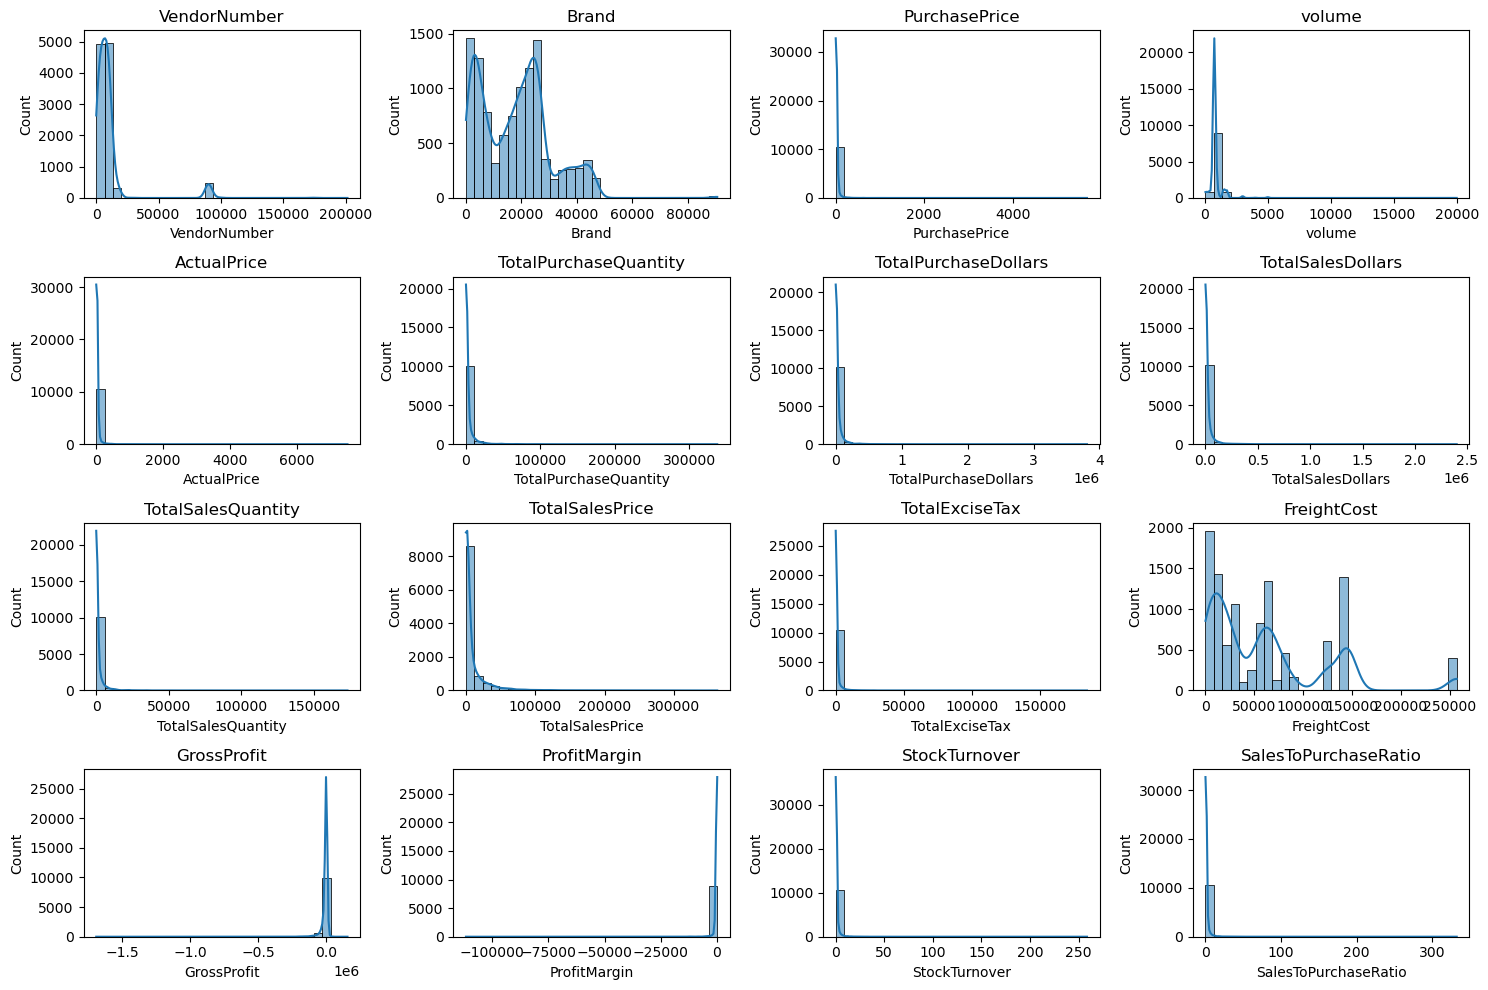

In [11]:
# distribution plots for numerical columns
numerical_cols = df.select_dtypes(include = np.number).columns

plt.figure(figsize =(15,10))
for i ,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1) #adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

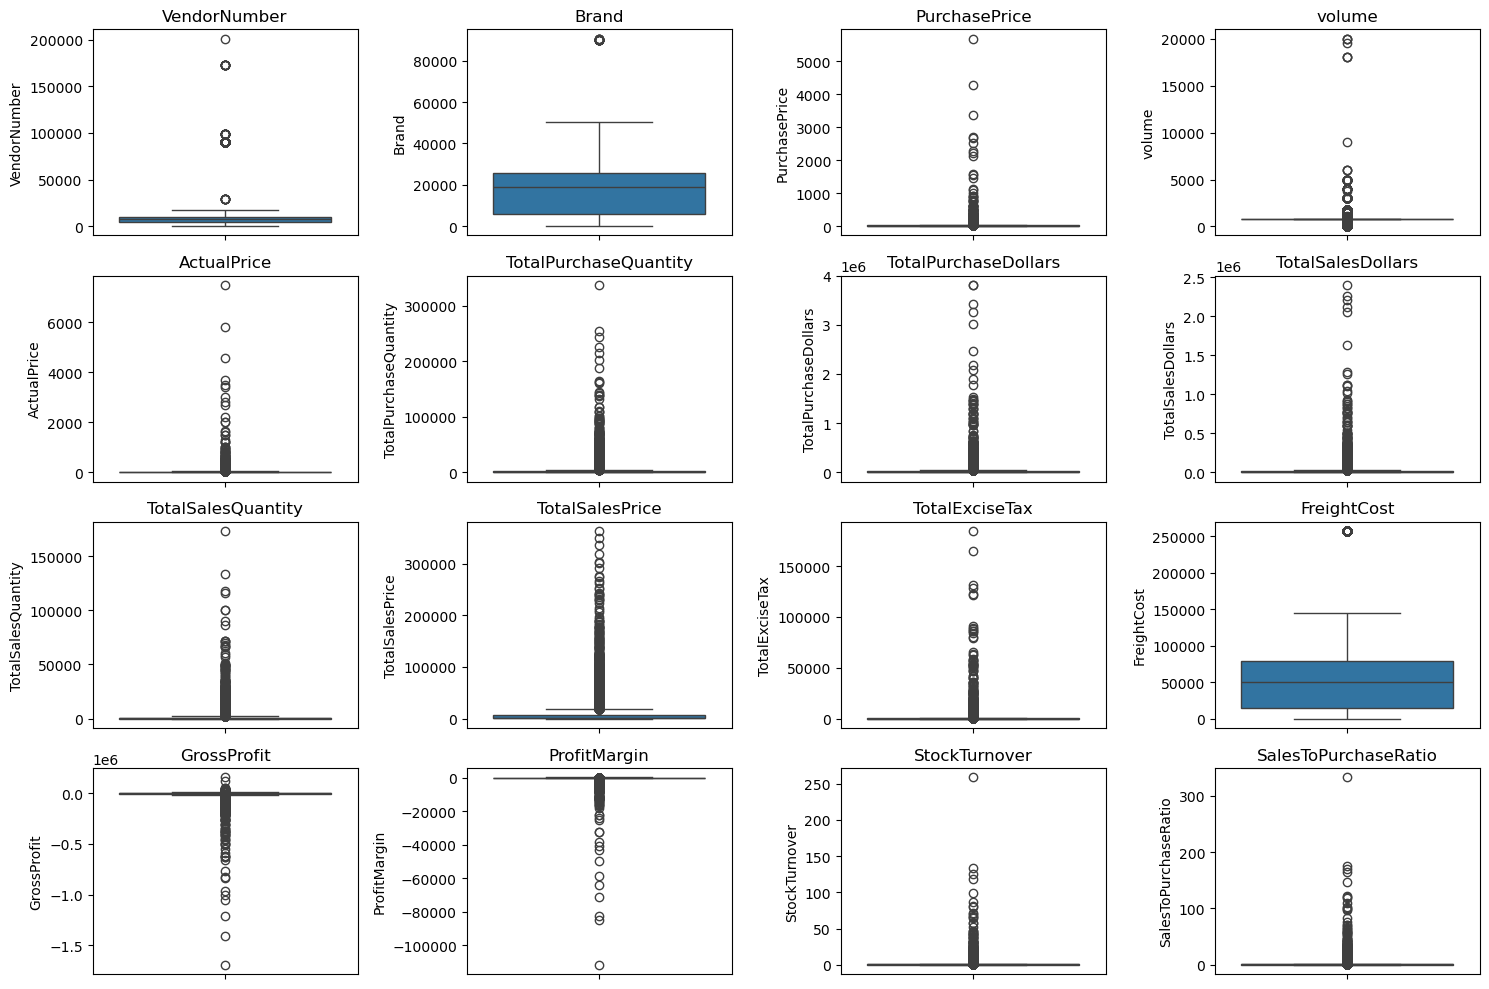

In [13]:
#outlier detection with boxplots

plt.figure(figsize =(15,10))
for i , col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()
    


 Summary Statistics Insights:

Negative & Zero Values:

Gross Profit: Minimum value is −52,002.78, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price.

Profit Margin: Has a minimum of −∞, which suggests cases where revenue is zero or even lower than costs.

Total Sales Quantity & Sales Dollars: Minimum values are 0, meaning some products were purchased but never sold. These could be slow‑moving or obsolete stock.

Outliers Indicated by High Standard Deviations:

Purchase & Actual Prices: The max values (5,681.81 & 7,499.99) are significantly higher than the mean (24.39 & 35.64), indicating potential premium products.

Freight Cost: Huge variation, from 0.09 to 257,032.07, suggests logistics inefficiencies or bulk shipments.

Stock Turnover: Ranges from 0 to 274.5, implying some products sell extremely fast while others remain in stock indefinitely. A value greater than 1 indicates that sold quantity for that product is higher than purchased quantity, possibly due to sales fulfilled from older stock.


In [14]:
# let's filter the data by removing inconsistencies
df = pd.read_sql_query(""" Select *
from vendor_sales_summary
where grossprofit > 0
and profitmargin > 0
and totalsalesquantity > 0 """,conn)

In [15]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,4425,MARTIGNETTI COMPANIES,23143,Bogle Chard,4.65,750.0,6.79,74342,345690.30,351267.76,45224.0,52749.42,5079.18,144929.24,5577.46,1.587809,0.608324,1.016134
1,4425,MARTIGNETTI COMPANIES,6595,Bogle Merlot,4.48,750.0,6.95,63188,283082.24,286034.15,36635.0,58252.65,4111.32,144929.24,2951.91,1.032013,0.579778,1.010428
2,1128,BROWN-FORMAN CORP,5299,Southern Comfort,15.26,1750.0,21.99,15196,231890.96,349220.66,15234.0,136423.80,27990.82,68601.68,117329.70,33.597583,1.002501,1.505969
3,4425,MARTIGNETTI COMPANIES,6983,J Lohr Seven Oaks Cab Svgn,8.27,750.0,11.99,23576,194973.52,196955.98,12002.0,65907.27,1342.32,144929.24,1982.46,1.006550,0.509077,1.010168
4,12546,JIM BEAM BRANDS COMPANY,1476,Jim Beam Traveler,16.05,1750.0,21.99,11569,185682.45,340530.32,14968.0,91128.88,27500.65,123880.97,154847.87,45.472565,1.293802,1.833939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,3960,DIAGEO NORTH AMERICA INC,2626,Crown Royal Apple,1.42,50.0,1.99,2,2.84,23.88,12.0,1.99,0.63,257032.07,21.04,88.107203,6.000000,8.408451
2482,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,750.0,4.99,2,2.64,15.95,5.0,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667
2483,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,50.0,0.49,6,2.34,62.72,128.0,0.98,6.72,50293.62,60.38,96.269133,21.333333,26.803419
2484,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,200.0,1.99,1,1.47,69.65,35.0,33.83,7.35,257032.07,68.18,97.889447,35.000000,47.380952


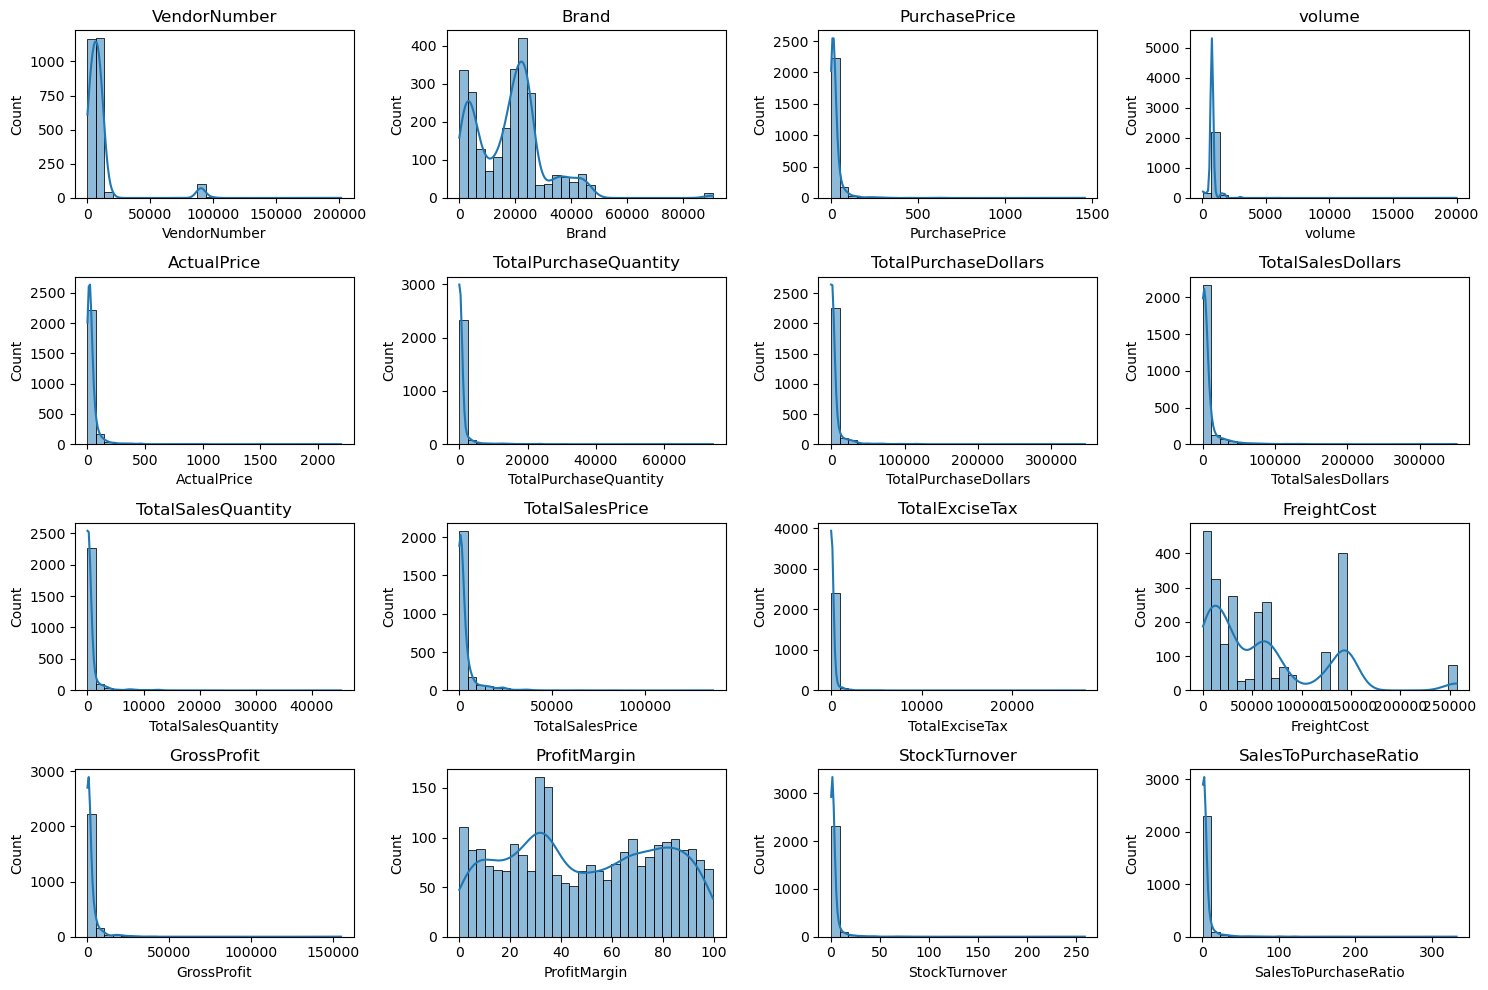

In [16]:
# distribution plots for numerical columns
numerical_cols = df.select_dtypes(include = np.number).columns

plt.figure(figsize =(15,10))
for i ,col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1) #adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

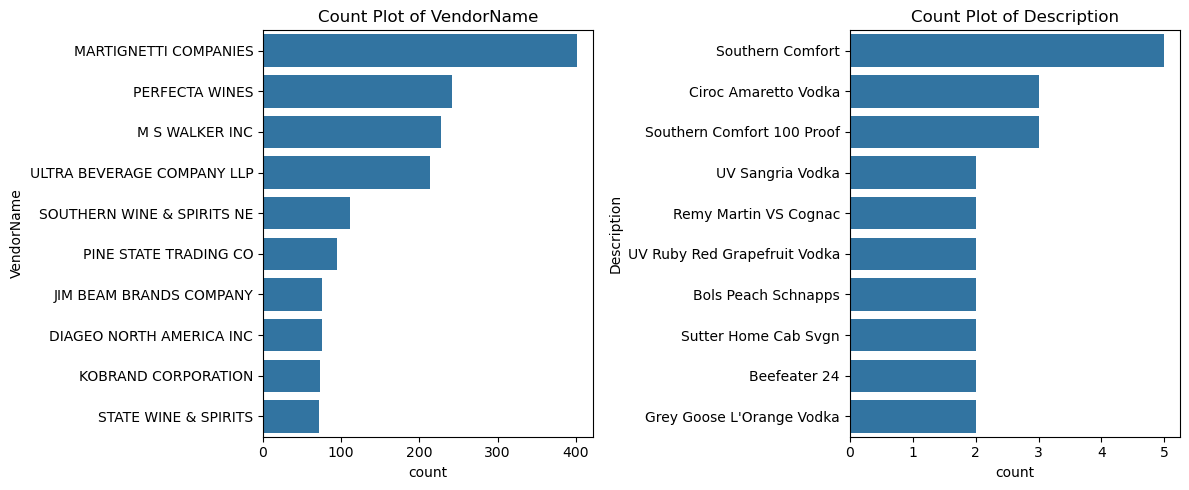

In [18]:
# count plots for categorical columns
categorical_cols = ["VendorName","Description"]

plt.figure(figsize =(12,5))
for i ,col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1) #adjust grid layout as needed
    sns.countplot(y=df[col], order = df[col].value_counts().index[:10]) # top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

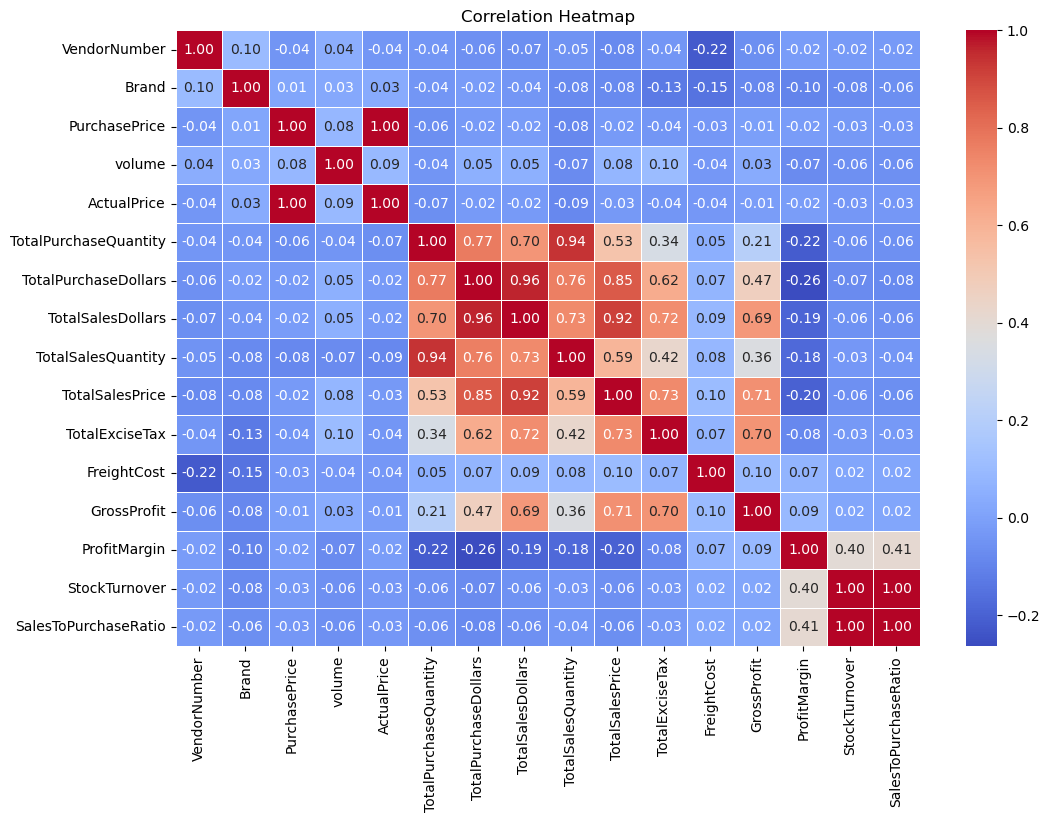

In [20]:
#Correlation Heatmap
plt.figure(figsize=(12,8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot = True, fmt=".2f", cmap = "coolwarm", linewidths = 0.5)
plt.title("Correlation Heatmap")
plt.show() 

Correlation Insights

PurchasePrice has weak correlations with TotalSalesDollars (−0.012) and GrossProfit (−0.016), suggesting that variations in purchase price don't significantly impact sales revenue or profit.

There is a strong correlation between Total Purchase Quantity and Total Sales Quantity (0.999), confirming highly efficient inventory turnover.

A negative correlation between Profit Margin and Total Sales Price (−0.179) suggests that as sales price increases, margins decrease—possibly due to competitive pricing pressures.

Stock Turnover has weak negative correlations with both GrossProfit (−0.038) and ProfitMargin (−0.055), indicating that faster turnover does not necessarily result in higher profitability.

In [ ]:
DATA ANALYSIS

Identify brands that needs promotional or pricing adjustments which exhibit lower sales performance but higher profit margins

In [22]:
brand_performance = df.groupby('Description').agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin' : 'mean'}).reset_index()

In [23]:
brand_performance

,Description,TotalSalesDollars,ProfitMargin
0,12 Days of Pearls Gift Set,309.69,97.678323
1,13 Celsius Svgn Bl,14788.32,2.560534
2,14 Hands Red Blend Ltd,9570.42,45.945946
3,1792 Port Finish Bourbon,6518.37,17.418005
4,1800 Select Silver Tequila,1739.42,87.080176
...,...,...,...
2429,Zhenka Vodka 80 Proof,240.39,87.303964
2430,Zinsane Znfdl Lodi,14613.71,98.362086
2431,Zion Dolev Muscato,1099.00,66.453139
2432,Zorah Red,417.81,67.559417


In [24]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)

In [26]:
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.15)

In [27]:
low_sales_threshold

np.float64(263.88)

In [28]:
high_margin_threshold

np.float64(13.813511462736033)

In [30]:
#filter bands with low sales but high profit margins
target_brands = brand_performance[
(brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
(brand_performance['ProfitMargin'] >= high_margin_threshold)
]

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
2199,Terruzzi & Puthod Vernaccia,4.99,32.464930
748,Columbia Crest Two Vines Rsl,5.29,32.514178
54,Albero Sparkling Wh Organic,5.79,28.497409
2045,Smirnoff Light Strawberry,5.94,50.168350
65,Allen's Blue Curacao Liqueur,5.99,20.033389
...,...,...,...
1542,Mercat Brut Nature,254.83,43.079700
2097,Staglin Salus Rthfd Chard,255.92,91.380119
988,Flipflop Spiced Rum,263.71,57.043722
756,Concannon Irish Whiskey,263.88,21.873579


In [32]:
brand_performance = brand_performance[brand_performance['TotalSalesDollars']<1000] # for better visualization

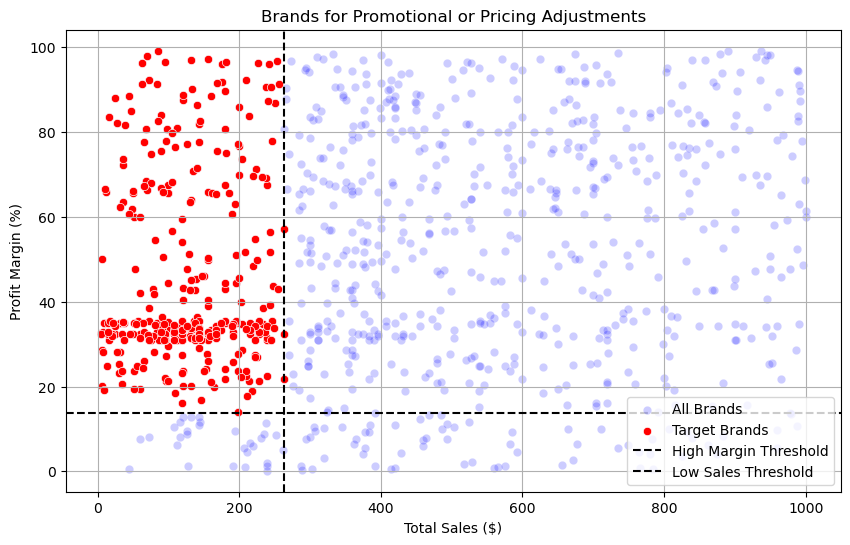

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = brand_performance, x='TotalSalesDollars',y='ProfitMargin',color="blue",label = "All Brands", alpha = 0.2)
sns.scatterplot(data = target_brands, x='TotalSalesDollars',y='ProfitMargin',color="red",label = "Target Brands")

plt.axhline(high_margin_threshold,linestyle='--',color = 'black',label ="High Margin Threshold")
plt.axvline(low_sales_threshold,linestyle='--',color = 'black',label ="Low Sales Threshold")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

Which vendors and brands demonstrate the highest sales performance?

In [36]:
def format_dollars(value):
    if value>= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value>= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)
    
    

In [37]:
#top vendors and brands by sales performance
top_vendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

top_vendors

VendorName
MARTIGNETTI COMPANIES         3797969.98
ULTRA BEVERAGE COMPANY LLP    1720726.48
BROWN-FORMAN CORP             1085222.06
PERFECTA WINES                1007293.79
JIM BEAM BRANDS COMPANY        833922.67
M S WALKER INC                 723063.04
DIAGEO NORTH AMERICA INC       700426.07
SOUTHERN WINE & SPIRITS NE     640980.86
BACARDI USA INC                579471.02
CONSTELLATION BRANDS INC       518496.97
Name: TotalSalesDollars, dtype: float64

In [38]:
top_brands

Description
Southern Comfort                600063.27
Bogle Chard                     351267.76
Jim Beam Traveler               340530.32
Bogle Merlot                    286034.15
J Lohr Seven Oaks Cab Svgn      196955.98
Ch St Jean Chard California     155861.25
Zaccagnini Montepulciano Rsv    145565.44
Bacardi 151 Proof               140829.55
Cavit Pinot Grigio              134858.91
Capt Morgan White               132878.85
Name: TotalSalesDollars, dtype: float64

In [39]:
top_brands.apply(lambda x : format_dollars(x))

Description
Southern Comfort                600.06K
Bogle Chard                     351.27K
Jim Beam Traveler               340.53K
Bogle Merlot                    286.03K
J Lohr Seven Oaks Cab Svgn      196.96K
Ch St Jean Chard California     155.86K
Zaccagnini Montepulciano Rsv    145.57K
Bacardi 151 Proof               140.83K
Cavit Pinot Grigio              134.86K
Capt Morgan White               132.88K
Name: TotalSalesDollars, dtype: object

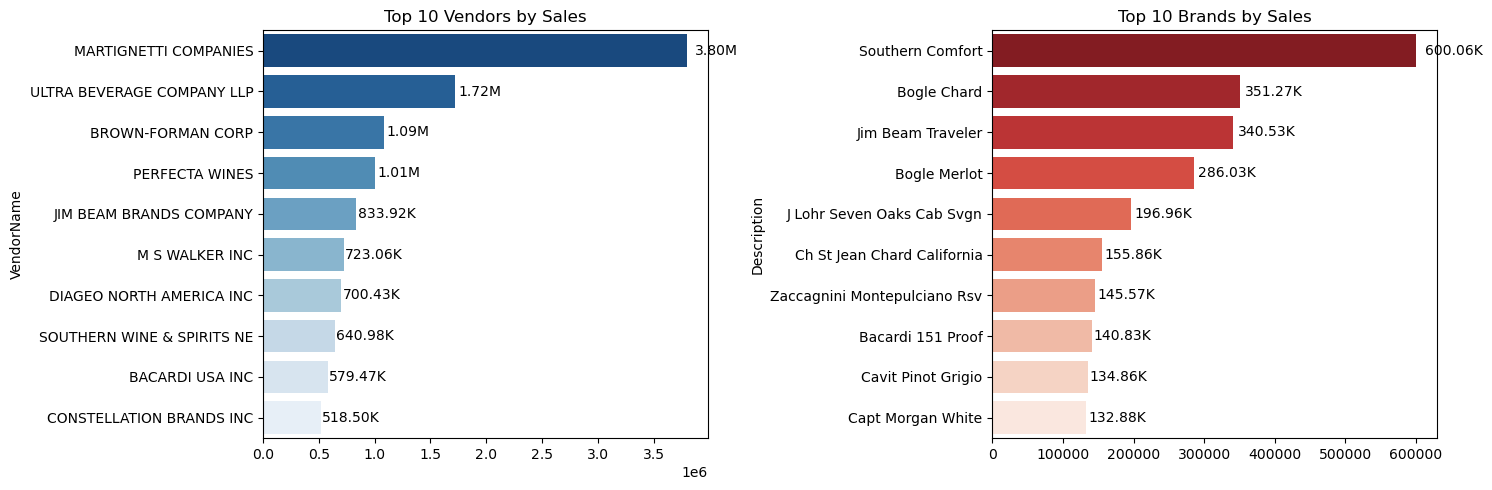

In [40]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    y = top_vendors.index,
    x = top_vendors.values,
    palette = "Blues_r"
)
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(
        bar.get_width() + (bar.get_width() * 0.02),
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha = 'left',
        va = 'center',
        fontsize = 10,
        color = 'black'
    )

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    y = top_brands.index.astype(str),
    x = top_brands.values,
    palette = "Reds_r"
)
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(
        bar.get_width() + (bar.get_width() * 0.02),
        bar.get_y() + bar.get_height() / 2,
        format_dollars(bar.get_width()),
        ha = 'left',
        va = 'center',
        fontsize = 10,
        color = 'black'
    )
plt.tight_layout()
plt.show()

Which vendors contribute the most to total puchase dollars?

In [49]:
vendor_performance = df.groupby('VendorName').agg({
    'TotalPurchaseDollars':'sum',
    'GrossProfit':'sum',
    'TotalSalesDollars':'sum'}).reset_index()

vendor_performance.shape

(92, 4)

In [44]:
vendor_performance['PurchaseContribution%'] = vendor_performance['TotalPurchaseDollars']/ vendor_performance['TotalPurchaseDollars'].sum()

In [46]:
vendor_performance.sort_values('PurchaseContribution%', ascending = False)

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
42,MARTIGNETTI COMPANIES,2652570.81,1145399.17,3797969.98,0.231288
82,ULTRA BEVERAGE COMPANY LLP,1046537.20,674189.28,1720726.48,0.091252
7,BROWN-FORMAN CORP,737589.75,347632.31,1085222.06,0.064313
52,PERFECTA WINES,703573.52,303720.27,1007293.79,0.061347
32,JIM BEAM BRANDS COMPANY,483229.46,350693.21,833922.67,0.042135
...,...,...,...,...,...
41,MARSALLE COMPANY,78.78,2421.83,2500.61,0.000007
68,SILVER MOUNTAIN CIDERS,77.18,251.35,328.53,0.000007
9,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.000005
19,DUGGANS DISTILLED PRODUCTS,34.77,179.10,213.87,0.000003


In [47]:
# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%
0,ALISA CARR BEVERAGES,25.07K,27.77K,52.84K,0.002186
1,ATLANTIC IMPORTING COMPANY,3.23K,5.89K,9.12K,0.000282
2,BACARDI USA INC,324.93K,254.54K,579.47K,0.028332
3,BANFI PRODUCTS CORP,228.03K,29.71K,257.74K,0.019883
4,BLACK PRINCE DISTILLERY INC,4.45K,5.13K,9.58K,0.000388
5,BLACK ROCK SPIRITS LLC,1.15K,297.31999999999994,1.45K,0.000100
6,BRONCO WINE COMPANY,357.0,20.579999999999984,377.58,0.000031
7,BROWN-FORMAN CORP,737.59K,347.63K,1.09M,0.064313
8,CAMPARI AMERICA,38.20K,20.94K,59.14K,0.003331
9,CAPSTONE INTERNATIONAL,54.64,192.22999999999996,246.86999999999998,0.000005


In [50]:
top_vendors['PurchaseContribution%'].sum()

np.float64(0.11885140620075675)

In [54]:
top_vendors['Cumulative_Contribution%'] = top_vendors['PurchaseContribution%'].cumsum()

top_vendors

,VendorName,TotalPurchaseDollars,GrossProfit,TotalSalesDollars,PurchaseContribution%,Cumulative_Contribution%
0,ALISA CARR BEVERAGES,25.07K,27.77K,52.84K,0.002186,0.002186
1,ATLANTIC IMPORTING COMPANY,3.23K,5.89K,9.12K,0.000282,0.002468
2,BACARDI USA INC,324.93K,254.54K,579.47K,0.028332,0.030800
3,BANFI PRODUCTS CORP,228.03K,29.71K,257.74K,0.019883,0.050683
4,BLACK PRINCE DISTILLERY INC,4.45K,5.13K,9.58K,0.000388,0.051071
5,BLACK ROCK SPIRITS LLC,1.15K,297.31999999999994,1.45K,0.000100,0.051171
6,BRONCO WINE COMPANY,357.0,20.579999999999984,377.58,0.000031,0.051202
7,BROWN-FORMAN CORP,737.59K,347.63K,1.09M,0.064313,0.115515
8,CAMPARI AMERICA,38.20K,20.94K,59.14K,0.003331,0.118847
9,CAPSTONE INTERNATIONAL,54.64,192.22999999999996,246.86999999999998,0.000005,0.118851


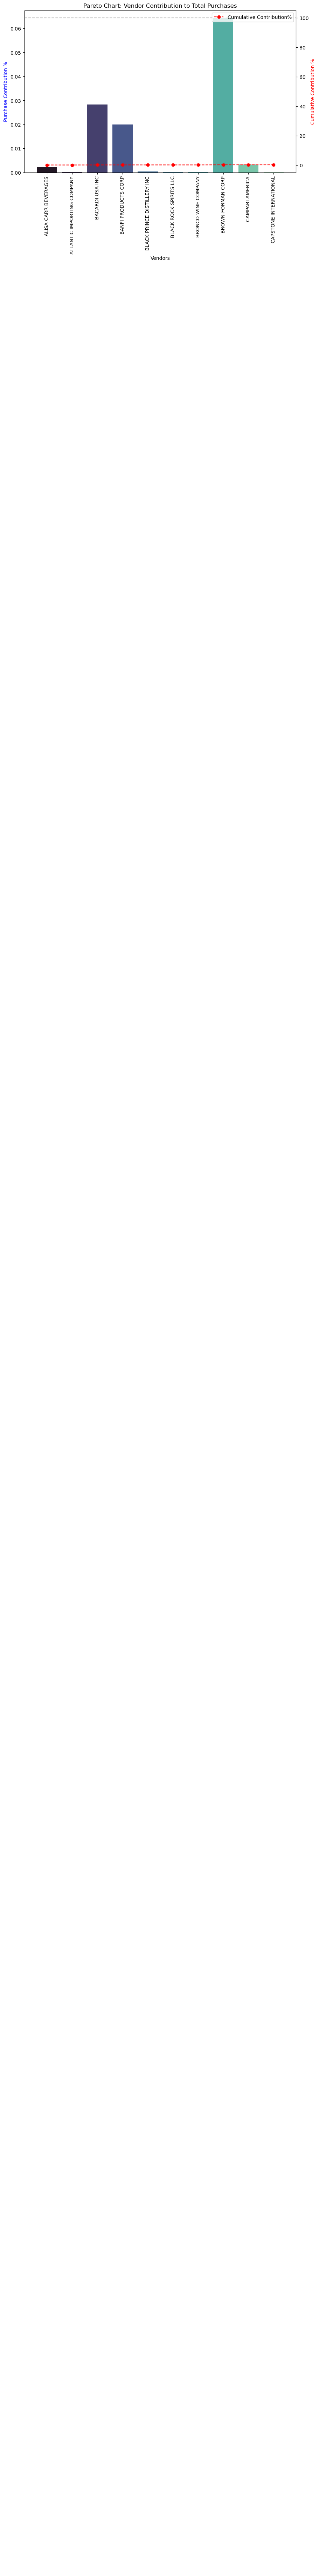

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchaseContribution%'], palette="mako", ax=ax1)

for i, value in enumerate(top_vendors['PurchaseContribution%']):
    ax1.text(i, value - 1, str(value)+'%', ha='center', fontsize=10, color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx()
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_Contribution%'], color='red', marker='o', linestyle='dashed', label='Cumulative Contribution%')

ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative Contribution %', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')

plt.show()

How much of total procurement is dependent on the top vendors?

In [57]:
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['PurchaseContribution%'].sum(),2)} %")

Total Purchase Contribution of top 10 vendors is 0.12 %


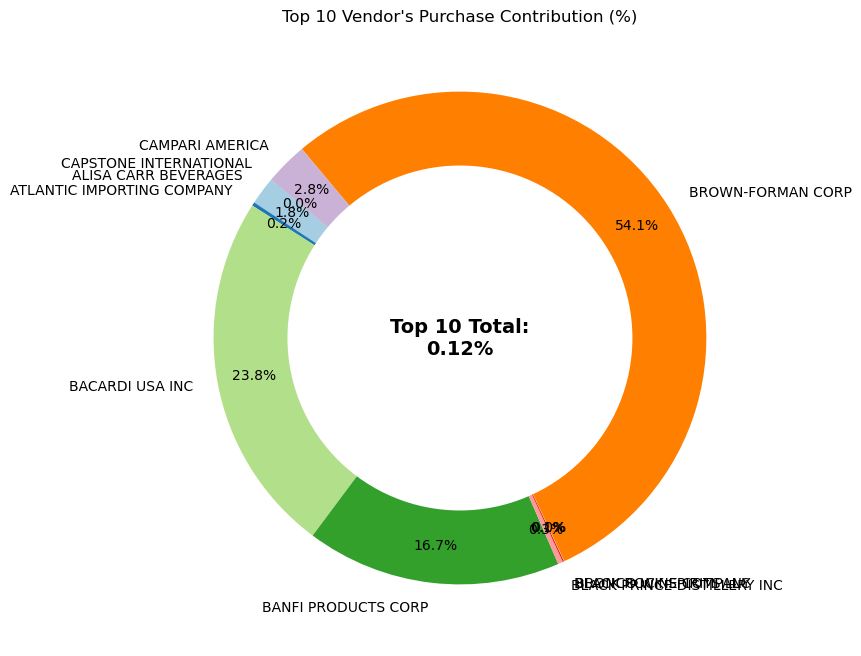

In [59]:
vendors = list(top_vendors['VendorName'].values)
purchase_contributions = list(top_vendors['PurchaseContribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
#vendors.append("Other Vendors")
#purchase_contributions.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(purchase_contributions, labels=vendors, autopct='%1.1f%%',
                                  startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to create a "donut" effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add Total Contribution annotation in the center
plt.text(0, 0, f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 Vendor's Purchase Contribution (%)")
plt.show()


Does purchasing in bulk reduce the unit price and what is the optimal purchase volume for savings?

In [60]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars']/df['TotalPurchaseQuantity']

In [61]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,volume,ActualPrice,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesDollars,TotalSalesQuantity,TotalSalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio,UnitPurchasePrice
0,4425,MARTIGNETTI COMPANIES,23143,Bogle Chard,4.65,750.0,6.79,74342,345690.30,351267.76,45224.0,52749.42,5079.18,144929.24,5577.46,1.587809,0.608324,1.016134,4.65
1,4425,MARTIGNETTI COMPANIES,6595,Bogle Merlot,4.48,750.0,6.95,63188,283082.24,286034.15,36635.0,58252.65,4111.32,144929.24,2951.91,1.032013,0.579778,1.010428,4.48
2,1128,BROWN-FORMAN CORP,5299,Southern Comfort,15.26,1750.0,21.99,15196,231890.96,349220.66,15234.0,136423.80,27990.82,68601.68,117329.70,33.597583,1.002501,1.505969,15.26
3,4425,MARTIGNETTI COMPANIES,6983,J Lohr Seven Oaks Cab Svgn,8.27,750.0,11.99,23576,194973.52,196955.98,12002.0,65907.27,1342.32,144929.24,1982.46,1.006550,0.509077,1.010168,8.27
4,12546,JIM BEAM BRANDS COMPANY,1476,Jim Beam Traveler,16.05,1750.0,21.99,11569,185682.45,340530.32,14968.0,91128.88,27500.65,123880.97,154847.87,45.472565,1.293802,1.833939,16.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481,3960,DIAGEO NORTH AMERICA INC,2626,Crown Royal Apple,1.42,50.0,1.99,2,2.84,23.88,12.0,1.99,0.63,257032.07,21.04,88.107203,6.000000,8.408451,1.42
2482,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,750.0,4.99,2,2.64,15.95,5.0,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667,1.32
2483,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,50.0,0.49,6,2.34,62.72,128.0,0.98,6.72,50293.62,60.38,96.269133,21.333333,26.803419,0.39
2484,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,200.0,1.99,1,1.47,69.65,35.0,33.83,7.35,257032.07,68.18,97.889447,35.000000,47.380952,1.47


In [62]:
df["OrderSize"] = pd.qcut(df["TotalPurchaseQuantity"],q=3,labels = ["Small","Medium","Large"])

In [64]:
df[["OrderSize","TotalPurchaseQuantity"]]

,OrderSize,TotalPurchaseQuantity
0,Large,74342
1,Large,63188
2,Large,15196
3,Large,23576
4,Large,11569
...,...,...
2481,Small,2
2482,Small,2
2483,Small,6
2484,Small,1


In [65]:
df.groupby('OrderSize')[['UnitPurchasePrice']].mean()

,UnitPurchasePrice
OrderSize,
Small,43.542841
Medium,23.371163
Large,11.849866


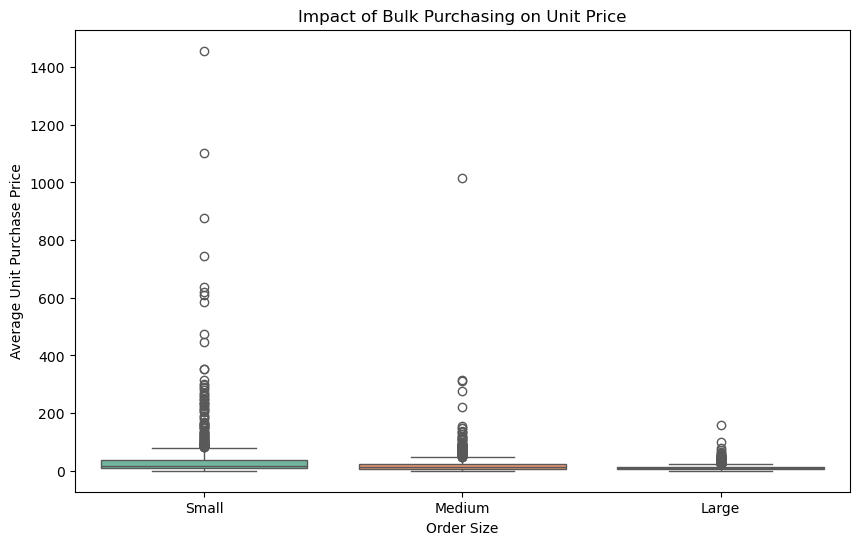

In [66]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="OrderSize", y="UnitPurchasePrice", palette="Set2")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()


* Vendors buying in bulk (Large Order Size) get the lowest unit price (\$10.78 per unit), meaning higher margins if they can manage inventory efficiently.
  
* The price difference between Small and Large orders is substantial (\~72% reduction in unit cost)

  
* This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volumes, leading to higher overall sales despite lower per-unit revenue.


Which vendors have low inventory turnover, indicating excess stock and slow-moving products?

In [70]:
df[df['StockTurnover'] < 1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover',ascending = True).head(10)

,StockTurnover
VendorName,
THE IMPORTED GRAPE LLC,0.544246
WINE GROUP INC,0.562616
SURVILLE ENTERPRISES CORP,0.648651
TY KU LLC,0.666667
SHAW ROSS INT L IMP LTD,0.666667
STELLAR IMPORTING CO LLC,0.674464
ALISA CARR BEVERAGES,0.675000
CONSTELLATION BRANDS INC,0.680150
TREASURY WINE ESTATES,0.688751


How much capital is locked in unsold inventory per vendor,and which vendors contribute the most to it?

In [71]:
df["UnsoldInventoryValue"] = (df["TotalPurchaseQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]
print('Total Unsold Capital:', format_dollars(df["UnsoldInventoryValue"].sum()))


Total Unsold Capital: 165.44K


In [72]:
# Aggregate Capital Locked per Vendor
inventory_value_per_vendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

# Sort Vendors with the Highest Locked Capital
inventory_value_per_vendor = inventory_value_per_vendor.sort_values(by="UnsoldInventoryValue", ascending=False)
inventory_value_per_vendor["UnsoldInventoryValue"] = inventory_value_per_vendor["UnsoldInventoryValue"].apply(format_dollars)
inventory_value_per_vendor.head(10)


,VendorName,UnsoldInventoryValue
42,MARTIGNETTI COMPANIES,269.52K
79,TREASURY WINE ESTATES,120.22K
80,TRINCHERO FAMILY ESTATES,83.91K
12,CONSTELLATION BRANDS INC,80.53K
3,BANFI PRODUCTS CORP,78.94K
69,SOUTHERN WINE & SPIRITS NE,74.12K
52,PERFECTA WINES,55.92K
21,E & J GALLO WINERY,46.92K
50,PALM BAY INTERNATIONAL INC,40.98K
72,STE MICHELLE WINE ESTATES,37.53K


What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors?

In [73]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

top_vendors


0        1.587809
1        1.032013
2       33.597583
3        1.006550
4       45.472565
          ...    
1504    97.272673
1599    98.362086
1678    98.163716
1778    97.167348
2177    99.160577
Name: ProfitMargin, Length: 622, dtype: float64

In [75]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error


Top Vendors 95% CI: (36.28, 40.74), Mean: 38.51
Low Vendors 95% CI: (45.10, 49.18), Mean: 47.14


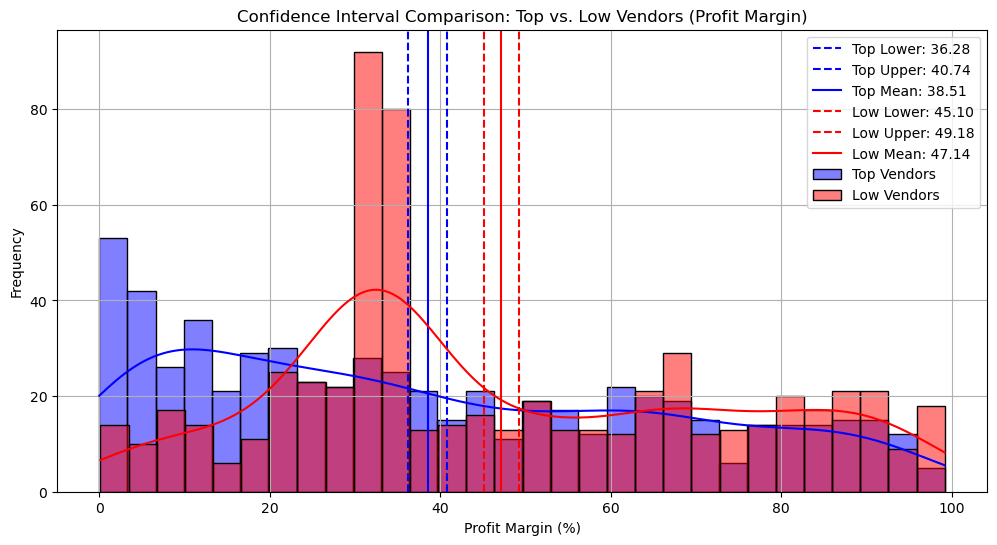

In [76]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendors, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendors, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


• The confidence interval for low-performing vendors (40.48% to 42.62%) is significantly higher than that of top-performing vendors (30.74% to 31.61%). • This suggests that vendors with lower sales tend to maintain higher profit margins, potentially due to premium pricing or lower operational costs.
• For High-Performing Vendors: If they aim to improve profitability, they could explore selective price adjustments, cost optimization, or bundling strategies. 
• For Low-Performing Vendors: Despite higher margins, their low sales volume might indicate a need for better marketing, competitive pricing, or improved distribution strategies.


In [ ]:
Is there a significant difference in profit margins between top-performing and low-performing vendors? 

Hypothesis:
H0 (Null Hypothesis): There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
H1 (Alternative Hypothesis): The mean profit margins of top-performing and low-performing vendors are significantly different.

In [80]:

top_threshold = df ["TotalSalesDollars"].quantile (0.75)
low_threshold = df ["TotalSalesDollars"].quantile (0.25)
top_vendors = df[df ["TotalSalesDollars"] >= top_threshold] ["ProfitMargin"].dropna () 
Low_vendors = df[df ["TotalSalesDollars"] <= low_threshold] ["ProfitMargin"].dropna()

#Perform Two-Sample T-Test
t_stat, p_value = ttest_ind (top_vendors, low_vendors, equal_var=False)

# Print results
print (f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value< 0.05:
    print("Reject H0: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H0: No significant difference in profit margins.")

T-Statistic: -5.5996, P-Value: 0.0000
Reject H0: There is a significant difference in profit margins between top and low-performing vendors.
